<a href="https://colab.research.google.com/github/luciacasass/APRENDIZAJE_AUTOMATICO_23_24/blob/main/AA_PRACTICA4_GRUPO_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 4 - Algoritmo Genético

Grupo A03

Lucía Casas Sierra, Alba López Devesa, Paula Redondo Sastre

In [55]:
pip install deap

##EJERCICIO 1
Encontrar los máximos de la función "picos"


$z = f(x,y) = 3(1-x)^2e^{-(x^2)-(y+1)^2} - 10(x/5-x^3-y^5)e^{-x^2-y^2} - 1/3e^{-(x+1)^2 - y^2}$

En el dominio
$(x, y) ∈ [-100, 100]$

Lo primero que haremos será representar la función en 3D para ver qué forma tiene nuestra función y así ver cómo afrontar la resolución del problema.

Text(0.5, 0, 'f(x,y)')

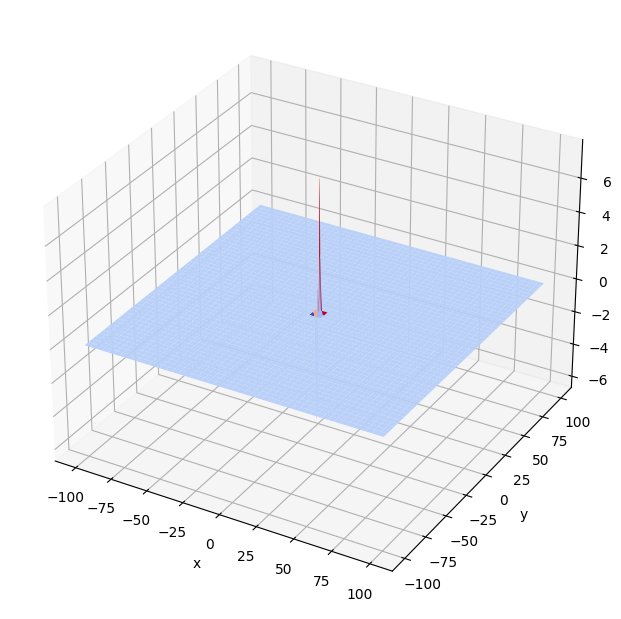

In [56]:
import random
import math
import numpy as np
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

def objective(x):
    if len(x) != 2:
        raise ValueError("Individual should be a two-element list")

    fitness_value = 3*((1-x[0])**2)*math.exp(-(x[0]**2)-(x[1]+1)**2) - 10*(x[0]/5-x[0]**3-x[1]**5)*math.exp(-x[0]**2-x[1]**2) - 1/3*math.exp(-(x[0]+1)**2-x[1]**2)

    return [fitness_value]

# Generamos vectores que barran todo el dominio
x = np.linspace(-100, 100, 1000)
y = np.linspace(-100, 100, 1000)

# Evaluamos todos los valores de las variables
x_ax, y_ax = np.meshgrid(x, y)
vals = np.c_[x_ax.ravel(), y_ax.ravel()]
fx = np.reshape([objective(val) for val in vals],(1000, 1000))

# Representamos los resultados obtenidos
figure_3d = plt.figure(figsize=(8,6))
ax = figure_3d.add_axes(Axes3D(figure_3d))
ax.plot_surface(x_ax, y_ax, fx, cmap=cm.coolwarm)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y)")

Como podemos ver, el dominio de la función es muy amplio y la verdaderamente importante de la función se encuentra en un dominio más reducido.
Esto traerá beneficios a la hora de ejecutar el algoritmo, pues si mantenemos el dominio original sería muy costoso computacionalmente llegar hasta el óptimo porque la mayoría de los puntos que se generen serán de valor $= 0$.

En consecuencia, la zona dónde se encuentra la información útil de la función no estaría correctamente representada.
Hemos decidido ajustar el dominio a $[-5, 5]$


Text(0.5, 0, 'f(x,y)')

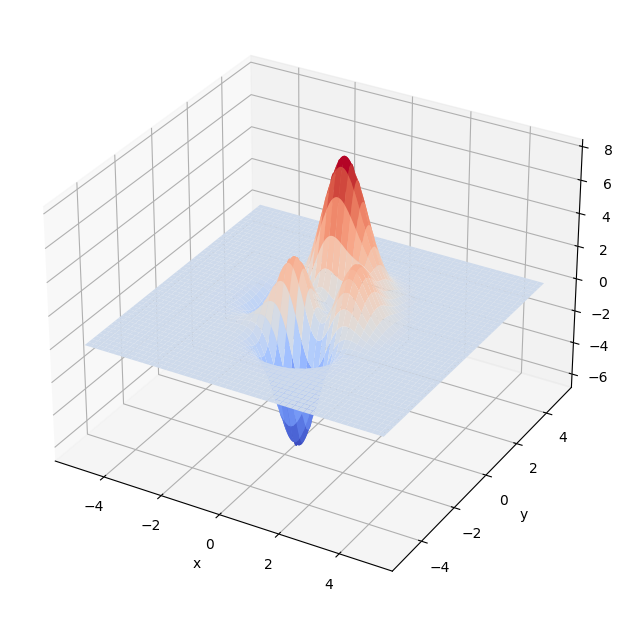

In [57]:
# Generamos vectores que barran todo el NUEVO dominio
x1 = np.linspace(-5, 5, 1000)
y1 = np.linspace(-5, 5, 1000)

# Evaluamos todos los valores de las variables
x_ax1, y_ax1 = np.meshgrid(x1, y1)
vals1 = np.c_[x_ax1.ravel(), y_ax1.ravel()]
fx1 = np.reshape([objective(val) for val in vals1],(1000, 1000))

# Representamos los resultados obtenidos
figure_3d = plt.figure(figsize=(6,6))
ax1 = figure_3d.add_axes(Axes3D(figure_3d))
ax1.plot_surface(x_ax1, y_ax1, fx1, cmap=cm.coolwarm)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("f(x,y)")

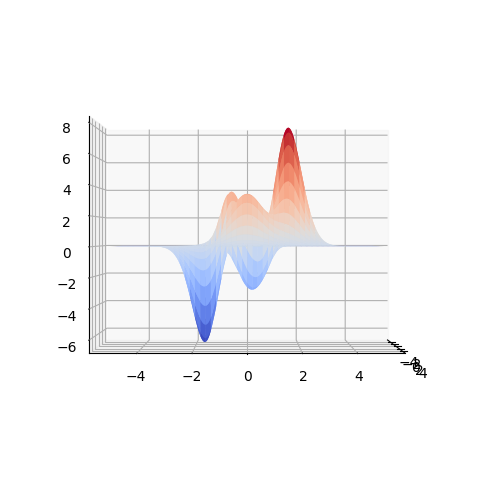

In [58]:
figure_3d = plt.figure(figsize=(8,6))
ax1 = figure_3d.add_subplot(111, projection='3d')
ax1.plot_surface(x_ax1, y_ax1, fx1, cmap=cm.coolwarm)
ax1.view_init(elev=0, azim=0)
plt.show()

**Resultados para cruce con un punto**

Lo primero que tenemos que hacer es definir nuestro algoritmo genético.
Lo primero es definir la manera de representación de nuestros individuos, hemos elegido representarlos como `float`. En nuestro caso, el fenotipo de los individuos serán números enteros decimales, y su genotipo, será su representación binaria en coma flotante, que consta de 64 bits por individuo.
El tamaño de la población inicial deberá estar en el rango de valores que va desde l hasta 2l, para asegurar la convergencia. En nuestro caso constará de 128 individuos.
Los individuos de la primera generación se crearán usando la función`random.uniform`, definida entre los valores de nuestro dominio adaptado. Esta función generará 128 números aleatorios comprendidos en el dominio $[-5, 5]$.
A continuación, definiremos las operaciones las operaciones genéticas que se utilizarán durante la ejecución del algoritmo evolutivo. Cada operación genética está asociada a una función específica de la biblioteca `DEAP`.
-	Cruce: En este caso hacemos cruce basado en un punto
-	Mutación: Los genes de cada individuo mutarán con una probabilidad del 20%. Si muta, el nuevo valor del gen se elige aleatoriamente el operador Mutación Gaussiana, de media 0 y desviación típica 4’5.
-	Selección de los individuos de la siguiente población: Se seleccionan los individuos de la siguiente generación. En este caso, el tamaño del torneo es 3, esto significa que se seleccionan tres individuos al azar y el mejor de ellos según la función de adaptación pasarán a la siguiente generación.
Estas operaciones son esenciales en un algoritmo evolutivo, ya que imitan los procesos de selección natural y reproducción en la evolución biológica.

Crearemos una función llamada `main` que es la que ejecutará el algoritmo genético. Esta función nos devolverá la mejor solución encontrada, así como toda la información sobre la evolución de la población.

El algoritmo se llevará a cabo durante 300 generaciones. Hemos decidido este número de generaciones porque como se verá más adelante, en el caso de dos puntos de cruce la convergencia hacia el máximo es más lenta y se necesitaran muchas más generaciones para que llegue al máximo.


**Justificación de elecciones**

La elección del método de torneo para la selección y la implementación de la sala de la fama en el algoritmo evolutivo se basa en consideraciones clave destinadas a mejorar la exploración y explotación del espacio de búsqueda, así como a facilitar la identificación de soluciones óptimas.

En cuanto al método de torneo para la selección, su adopción se justifica por su capacidad para fomentar la diversidad genética al seleccionar individuos aleatoriamente para participar en los torneos. Esta aleatoriedad contribuye a explorar diversas regiones del espacio de búsqueda, particularmente valioso en problemas complejos y multimodales como el de Rastrigin. Además, el método de torneo no garantiza la selección exclusiva de individuos más aptos, proporcionando así una cierta preservación de la diversidad en la población. Se probaron otros métodos como el roulette y random pero estos no mejoraban la convergencia, ya que tardaban muchas más generaciones en llegar a valores razonablemente buenos sabiendo que el mínimo teórico es 0.

En lo que respecta a la sala de la fama, su inclusión tiene como objetivo conservar el mejor individuo encontrado a lo largo de todo el proceso evolutivo. Esta característica es esencial para realizar un seguimiento claro de la mejor solución identificada, lo que facilita la evaluación del rendimiento del algoritmo y la obtención de la solución óptima. Además, la sala de la fama facilita el análisis posterior del rendimiento del algoritmo, permitiendo comprender la convergencia del mismo y evaluar su capacidad para encontrar soluciones óptimas. Asimismo, posibilita la comparación entre diferentes ejecuciones del algoritmo, proporcionando información valiosa sobre la consistencia del rendimiento y la capacidad del algoritmo para reproducir resultados óptimos de manera repetida.

gen	nevals	avg     	std    	min     	max    
0  	128   	0.162086	1.14352	-5.30329	6.32018
1  	78    	0.305189	0.911556	-2.22989	3.60833
2  	64    	0.67464 	1.18756 	-3.62821	3.70874
3  	65    	1.57066 	1.27541 	-1.78872	3.96055
4  	80    	2.26757 	1.5186  	-1.78872	7.42415
5  	86    	3.04198 	1.76077 	-1.38906	7.42415
6  	93    	3.9962  	1.77525 	-1.39092	7.42415
7  	84    	4.93351 	2.02361 	-1.94726	7.42415
8  	80    	6.2249  	1.86504 	-0.00224247	7.42415
9  	79    	6.88662 	1.55787 	-0.000363338	7.42415
10 	73    	7.07189 	1.56928 	-0.00733858 	7.42415
11 	81    	6.75867 	2.0935  	-0.148706   	7.82888
12 	76    	6.57706 	2.34979 	-1.31992    	7.82888
13 	84    	7.02692 	1.66184 	-2.65672e-11	7.82888
14 	86    	7.11664 	1.52024 	-3.45419e-08	7.82888
15 	60    	7.36236 	1.42939 	-3.79963    	7.82888
16 	78    	7.21377 	1.95517 	-3.04736e-05	7.88208
17 	88    	6.99014 	2.33125 	-0.00133795 	7.88208
18 	85    	7.35992 	1.83412 	-0.0525414  	7.88208
19 	77    	7.35837 	1.80722 	-0.0520928

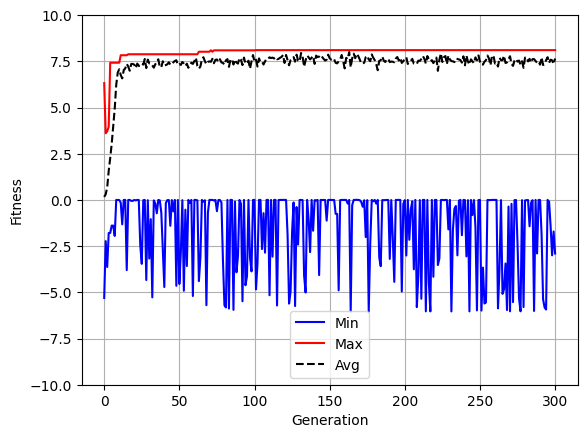

In [59]:
# Creamos los objetos para definir el problema y el tipo de individuo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Generación de genes
toolbox.register("attr_uniform", random.uniform, -5.0, 5.0)

# Generación de inviduos y población
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_uniform, 2)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual)

# Registro de operaciones genéticas
toolbox.register("evaluate", objective)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 4.5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def plot_evolucion(log):
    """
    Representa la evolución del mejor individuo en cada generación
    """
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_ave = log.select("avg")

    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_ave, "--k")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    ax1.set_ylim([-10, 10])
    ax1.legend(["Min", "Max", "Avg"], loc="lower center")
    plt.grid(True)
    plt.savefig("Convergencia.eps", dpi = 300)

def main():
    random.seed(0)
    CXPB, MUTPB, NGEN = 0.5, 0.2, 300
    population_size = 128
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    logbook = tools.Logbook()
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB,
                                       mutpb=MUTPB, ngen=NGEN, stats=stats,
                                       halloffame=hof, verbose=True)
    return hof, logbook

if __name__ == "__main__":
    best, log = main()
    print("Mejor fitness: %f" %best[0].fitness.values)
    print("Mejor individuo %s" %best[0])
    plot_evolucion(log)
    res_one = log.select("max")
    gen = log.select("gen")

En esta gráfica podemos ir viendo como evolucionan los valores del mejor individuo, peor individuo y la media a lo largo de las 300 generaciones.

Podemos ver como se consiguen valores muy cercanos al máximo desde antes de la generación 75 (aproximadamente).

**Resultados para cruce con dos puntos de cruce**

En este caso aplicamos el mismo algoritmo que en el caso anterior cambiando únicamente los puntos de cruces. En vez de generar un único punto, generaremos dos.

gen	nevals	avg     	std    	min     	max    
0  	128   	0.162086	1.14352	-5.30329	6.32018
1  	90    	0.360413	1.24582	-2.22989	7.37249
2  	71    	1.04585 	1.80522	-1.71703	7.98945
3  	68    	2.08332 	2.08099	-1.52304	7.98945
4  	89    	3.63854 	2.21115	-1.40252	7.98945
5  	69    	5.21755 	2.26729	-0.0256688	7.98945
6  	75    	6.94106 	1.95012	-1.64787  	7.98945
7  	63    	7.7322  	1.2099 	7.6858e-19	7.98945
8  	81    	7.56691 	1.75012	-0.0111512	7.98945
9  	59    	7.49167 	1.92795	-0.00594241	7.98945
10 	74    	7.52695 	1.97227	-3.88513   	7.98945
11 	83    	7.35023 	2.09972	-0.0108543 	7.98945
12 	76    	7.4353  	2.01631	-0.00151034	7.98945
13 	81    	7.40407 	2.04201	-1.7313    	7.98945
14 	69    	7.30158 	2.23013	-0.0590394 	7.98945
15 	68    	7.61515 	1.68779	-1.76307e-22	7.98945
16 	75    	7.45855 	1.93236	-3.30471e-18	7.98945
17 	78    	7.85629 	0.850871	3.68441e-14 	7.98945
18 	71    	7.36809 	2.04418 	-4.86878e-35	7.98945
19 	90    	7.29108 	2.30741 	-3.66379    	7.98945
20 	76

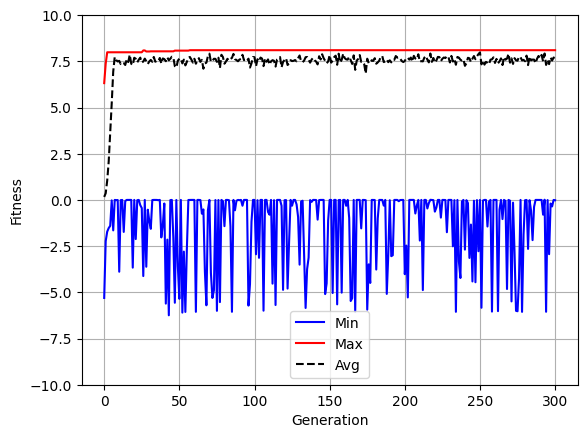

In [60]:
# Creamos los objetos para definir el problema y el tipo de individuo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Generación de genes
toolbox.register("attr_uniform", random.uniform, -5.0, 5.0)

# Generación de inviduos y población
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_uniform, 2)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual)

# Registro de operaciones genéticas
toolbox.register("evaluate", objective)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 4.5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    random.seed(0)
    CXPB, MUTPB, NGEN = 0.5, 0.2, 300
    population_size = 128
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    logbook = tools.Logbook()
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB,
                                       mutpb=MUTPB, ngen=NGEN, stats=stats,
                                       halloffame=hof, verbose=True)
    return hof, logbook

if __name__ == "__main__":
    best, log = main()
    print("Mejor fitness: %f" %best[0].fitness.values)
    print("Mejor individuo %s" %best[0])
    plot_evolucion(log)
    res_two = log.select("max")

**Comparación de resultados**

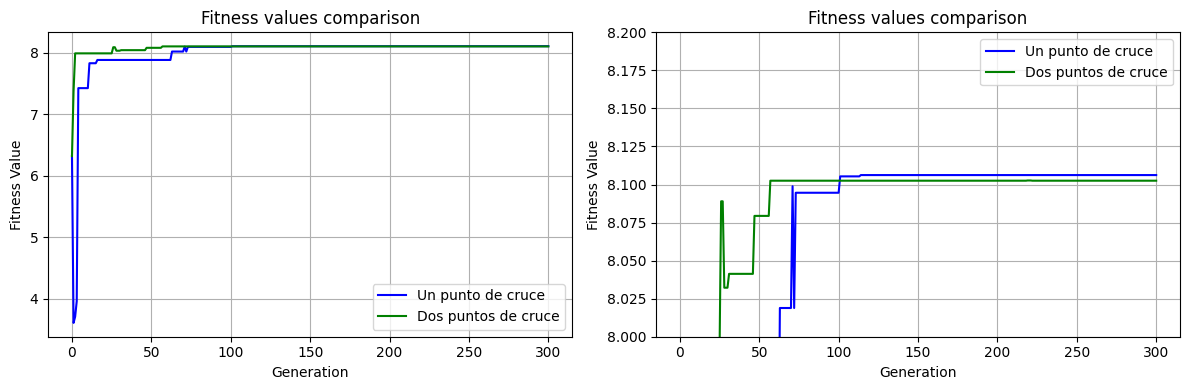

In [61]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(gen, res_one, label='Un punto de cruce', linestyle='-', color='blue')
plt.plot(gen, res_two, label='Dos puntos de cruce', linestyle='-', color='green')
plt.title('Fitness values comparison')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(gen, res_one, label='Un punto de cruce', linestyle='-', color='blue')
plt.plot(gen, res_two, label='Dos puntos de cruce', linestyle='-', color='green')
plt.title('Fitness values comparison')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.ylim(8, 8.2)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Se puede observar que el de dos puntos de cruce **comienza a aproximarse** al óptimo más rápido, pero el de un punto de cruce lo **alcanza** antes.

El algoritmo realizado con un punto de cruce coverge entorno a la iteración 120 con un valor de 8.10621 mientras que el de dos puntos de cruce en 300 iteraciones todavía no ha conseguido alcanzar ese valor, demostrando que, en este, el modelo con un solo punto de cruce.

**Código que mejora la convergencia y no utiliza puntos de cruce**

Se ha observado que la ejecución del algoritmo genético con la elección de un punto de cruce es más eficientes que la metodología para dos puntos de cruce. No obstante, la solución óptima al problema requiere un número relativamente alto de generaciones (alrededor de 120). Teniendo en cuenta que el trazado de la función del enunciado no muestra excesivas oscilaciones, tiene sentido intuir que su resolución da cabida a mejoras.

En este caso, partiendo de la premisa de que se estaba comparando la convergencia de diferentes métodos de cruce y habiendo probado previamente que la selección por torneo y la mutación gaussiana muestran los resultados más óptimos para la cuestión de estudio, se buscará mejorar los algoritmos previamente implementados a partir de la metodología elegida para el criterio de cruce.

Tras la prueba de distintas alternativas como el cruce uniforme y el cruce parcialmente coincidente o Partialy Matched Crossover, se ha llegado a la conclusión de que el algoritmo alcanza una mayor optimalidad cuando se emplea un operador de cruzamiento por mezcla o *blend crossover*.

El cruce por mezcla tiene por objetivo generar soluciones nuevas a partir del genotipo de los padres de forma que permita una exploración efectiva en el espacio de búsqueda. A continuación, se especificará el proceso que su algoritmo correspondiente sigue para calcular las nuevas generaciones:

1. Se seleccionan los individuos que actuarán como padres.

2. Para cada gen de los padres, determinaremos un rango en el cual se generará el gen del hijo.

3. Por cada gen en los padres, se elegirá aleatoriamente un valor perteneciente al rango establecido. Un parámetro de mezcla ```alpha``` decidirá la cercanía genética de los hijos a los padres.

4. Los nuevos hijos son el resultado del proceso anterior.

De acuerdo a la algoritmia de la herramienta *blend crossover*, el valor elegido para el parámetro ```alpha``` decidirá la similitud entre los padres y su descendencia; un valor bajo significa que los hijos se parecen más a los padres.

En la siguiente celda, se implementará el cruce por mezcla para ```alpha = 0.7```.

gen	nevals	avg     	std    	min     	max    
0  	128   	0.162086	1.14352	-5.30329	6.32018
1  	91    	0.43849 	1.23163	-1.81235	7.71408
2  	64    	1.11809 	1.84098	-3.63644	7.71408
3  	79    	2.20139 	2.61408	-4.75542	7.75211
4  	78    	3.71581 	2.68588	-3.67013	8.05988
5  	64    	5.85634 	2.26088	-1.86832	8.05988
6  	78    	6.89102 	1.97603	-0.133784	8.10206
7  	71    	7.37626 	1.84556	-3.79633e-65	8.10206
8  	94    	7.22395 	2.34586	-0.0172761  	8.10585
9  	75    	7.671   	1.68922	-0.000198394	8.10585
10 	83    	7.8808  	1.22437	-0.000193522	8.10612
11 	90    	7.14836 	2.56426	-0.95571    	8.10616
12 	77    	7.34489 	2.35677	-0.960865   	8.10617
13 	76    	7.26586 	2.52816	-6.08214    	8.10621
14 	71    	7.6208  	2.08013	-4.82701    	8.10621
15 	85    	7.68307 	1.90656	-5.55032    	8.10621
16 	84    	7.72843 	1.66629	-0.000304576	8.10621
17 	67    	7.56348 	1.8891 	1.08807e-72 	8.10621
18 	81    	7.55655 	1.93206	-3.31004e-13	8.10621
19 	79    	7.67482 	1.7457 	-0.00222674 	8.10621
20

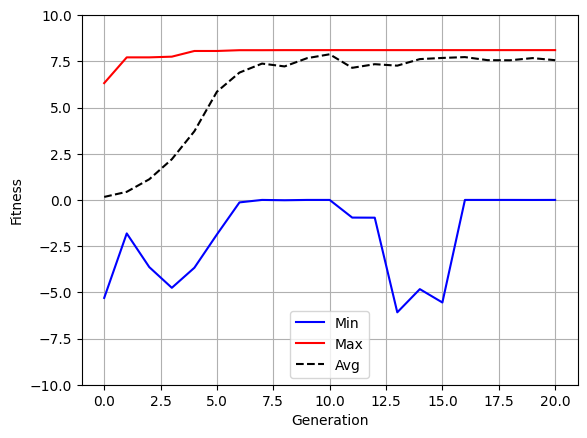

In [62]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Generación de genes
toolbox.register("attr_uniform", random.uniform, -5.0, 5.0)

# Generación de inviduos y población
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_uniform, 2)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual)

# Registro de operaciones genéticas
toolbox.register("evaluate", objective)
toolbox.register("mate", tools.cxBlend, alpha=0.7)
toolbox.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 4.5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    random.seed(0)
    CXPB, MUTPB, NGEN = 0.5, 0.2, 20
    population_size = 128
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    logbook = tools.Logbook()
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB,
                                       mutpb=MUTPB, ngen=NGEN, stats=stats,
                                       halloffame=hof, verbose=True)
    return hof, logbook

if __name__ == "__main__":
    best, log = main()
    print("Mejor fitness: %f" %best[0].fitness.values)
    print("Mejor individuo %s" %best[0])
    plot_evolucion(log)
    res_three = log.select("max")
    gen = log.select('gen')

A partir de los resultados del algoritmo que se han graficado así como la tabla de valores generada, se observa que se alcanza un valor de fitness máximo óptimo en tan solo 13 generaciones; aproximadamente se han requerido un 10% de las generaciones que el algoritmo de un punto de cruce necesitaba. Ello prueba la primera hipótesis sobre las posibilidades de optimización del problema inicial.

Asimismo, se ha de destacar el trazado de los valores mínimos encontrados. Vemos que la evolución de los valores mínimos de la función objetivo que se han logrado calcular en cada generación se caracterizan por una evolución muy inestable que oscila bastante. Esto se debe a que la configuración del algoritmo está orientada hacia la maximización de la función fitness. No obstante, se pueden interpretar los picos negativos en el trazado de los mínimos como momentos de exploración de individuos.

Las principales ventajas que ha presentado esta metodología de cruce se encuentran entorno al parámetro de mezcla, consiguiendo mantener una diversidad adecuada en la población que permita fases de exploración de individuos. Además, como consecuencia de esta diversidad poblacional, se consigue evitar una convergencia prematura al lograr escapar de soluciones subóptimas.


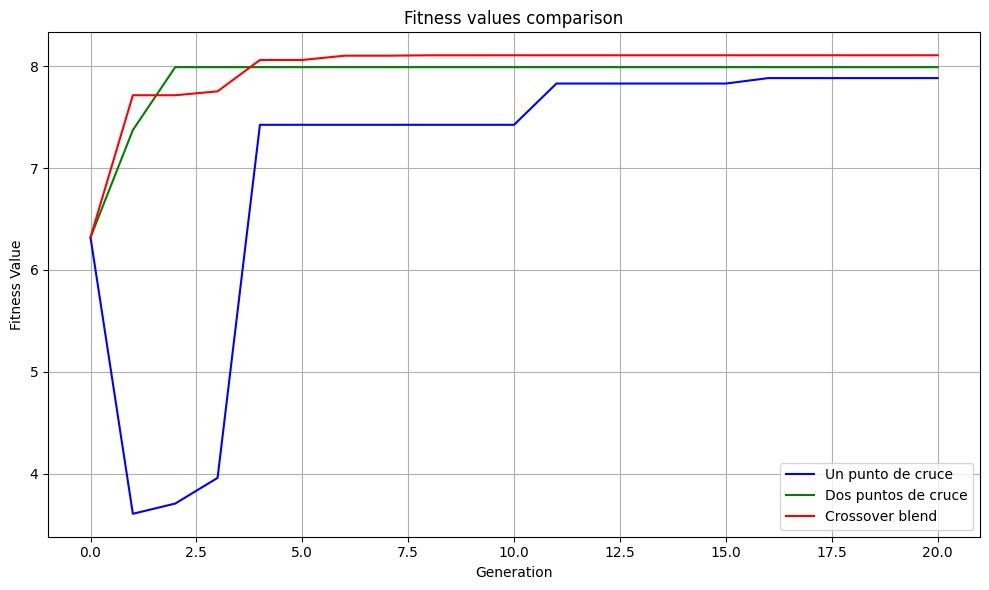

In [63]:
plt.figure(figsize=(10, 6))

plt.plot(gen, res_one[:gen[-1]+1], label='Un punto de cruce', linestyle='-', color='blue')
plt.plot(gen, res_two[:gen[-1]+1], label='Dos puntos de cruce', linestyle='-', color='green')
plt.plot(gen, res_three, label='Crossover blend', linestyle='-', color='red')
plt.title('Fitness values comparison')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

La gráfica anterior pone de relieve el aumento de la velocidad de convergencia de *crossover blend* en comparación con la metodología de los puntos de cruce, pues el algoritmo consigue encontrar valores por encima de 8 en tan sólo 4 generaciones.

## EJERCICIO 2

**Función de Rastringin**

La función de Rastrigin se emplea como una función de evaluación en problemas de optimización y algoritmos evolutivos. Concebida por Rastrigin, su propósito es presentar un desafío significativo para los algoritmos de optimización, especialmente en situaciones de no convexidad. La función exhibe numerosos mínimos locales, complicando la búsqueda del mínimo global y requiriendo enfoques de optimización robustos.

De particular interés es su capacidad para operar en espacios de alta dimensionalidad, ya que toma como entrada un vector de variables, permitiendo así evaluar la eficacia de algoritmos en problemas de optimización de gran dimensionalidad, una situación frecuente en aplicaciones prácticas.

La función de Rastrigin integra términos cuadráticos y cosenos, otorgándole una estructura regular y periódica. Este atributo presenta desafíos adicionales a los algoritmos de optimización, que deben ser capaces de manejar estas características para lograr convergencia adecuada. Asimismo, la definición de la función en un dominio acotado refleja condiciones de borde realistas presentes en problemas de optimización.

En la comunidad de investigación y desarrollo de algoritmos de optimización, la función de Rastrigin ha sido adoptada como un estándar para evaluar y comparar el rendimiento de distintos métodos de optimización. Al abordar la optimización de la función de Rastrigin, se espera que los algoritmos exhiban la capacidad de encontrar soluciones cercanas al mínimo global, a pesar de la presencia de múltiples mínimos locales y la complejidad inherente de la función.

La función de Rastringin para A = 10 se define como:

$f(x)=10n+\sum_{i=1}^{n}(x_i^2 −10cos(2πx_i))$

donde $x$ es un vector de variables de entrada, $n$ es la dimensión del vector $x$, y $x_i$ son los componentes individuales del vector.



In [64]:
# Definir la función Rastrigin
def rastrigin(x):
    if isinstance(x, np.ndarray):
          # La función toma un argumento x, que se espera que sea un vector, ya sea en forma de lista de Python o un array de NumPy.
          # En caso de que sea un array de NumPy, se convierte a una lista.
          x = x.tolist()

    A = 10
    fitness_value = A * len(x) + sum([(xi ** 2 - A * math.cos(2 * math.pi * xi)) for xi in x])
    return [fitness_value]

A continuación se genera una representación bidimensional de la función de Rastrigin en el dominio especificado, proporcionando los valores de la función para cada par de coordenadas x e y en la cuadrícula definida. Estos valores se almacenarán en una matriz y se utilizarán para la visualización tridimensional posteriormente en el código.

Text(0.5, 0, 'f(x,y)')

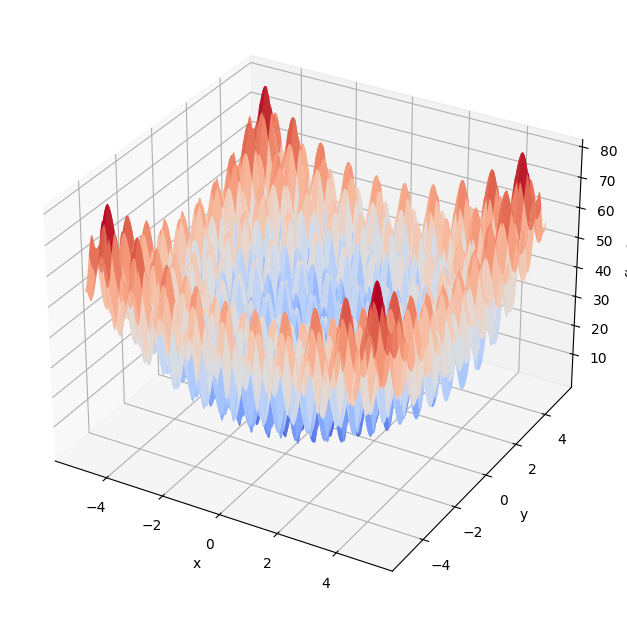

In [65]:
# Generamos vectores que barran todo el dominio
x2 = np.linspace(-5.12, 5.12, 1000)
y2 = np.linspace(-5.12, 5.12, 1000)

# Evaluamos todos los valores de las variables
x_ax2, y_ax2 = np.meshgrid(x2, y2)
vals2 = np.c_[x_ax2.ravel(), y_ax2.ravel()]
fx2 = np.reshape([rastrigin(val) for val in vals2],(1000, 1000))

# Representamos los resultados obtenidos
figure_3d = plt.figure(figsize=(8,6))
ax2 = figure_3d.add_axes(Axes3D(figure_3d))
ax2.plot_surface(x_ax2, y_ax2, fx2, cmap=cm.coolwarm)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("f(x,y)")

La representación tridimensional de la función de Rastrigin proporciona una perspectiva visual detallada de las características topológicas de la superficie de la función en el espacio bidimensional definido por las variables $x$ e $y$. En esta visualización, los ejes $x$ e $y$ representan las variables independientes, mientras que el eje $z$ refleja los valores de la función de Rastrigin $f(x, y)$. La evaluación de la función en una cuadrícula bidimensional en el rango $[-5.12, 5.12]$ para ambas variables revela patrones complejos inherentes a la función.

Observando la gráfica, se puede corroborar la presencia de múltiples mínimos locales distribuidos en la superficie de la función. Estos mínimos locales se manifiestan como valles en la representación tridimensional y sugieren la existencia de óptimos locales en el espacio de búsqueda. La complejidad de la función, caracterizada por su naturaleza no convexa y la presencia de términos cuadráticos y cosenos, se traduce en una topografía irregular con crestas y valles.

Además, la periodicidad evidente en la función de Rastrigin se refleja en patrones repetitivos en la gráfica tridimensional. La influencia de los términos cosenos en la función agrega una dimensión adicional a su complejidad, generando regiones con variaciones cíclicas.

La visualización tridimensional resalta la dificultad intrínseca de encontrar el mínimo global de la función de Rastrigin, ya que los algoritmos de optimización deben superar la presencia de múltiples mínimos locales y la topografía irregular de la superficie. La capacidad de adaptación y robustez de los algoritmos se pondría a prueba en la búsqueda de soluciones óptimas en este entorno no lineal y multimodal.


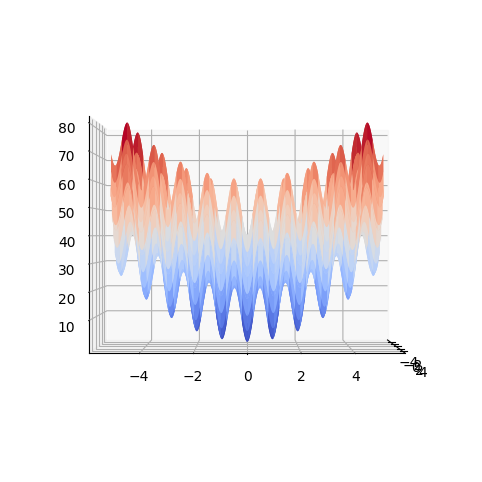

In [66]:
figure_3d = plt.figure(figsize=(8,6))
ax2 = figure_3d.add_subplot(111, projection='3d')
ax2.plot_surface(x_ax2, y_ax2, fx2, cmap=cm.coolwarm)
ax2.view_init(elev=0, azim=0)
plt.show()

La gráfica anterior es una visualización bidimensional que muestra las curvas de nivel de la función Rastringin en un plano.

**Código para un punto de cruce**

El código comienza por definir dos clases fundamentales utilizando el módulo `creator` de la biblioteca DEAP. La primera clase, `FitnessMin`, especifica un tipo de aptitud para la minimización. La segunda clase, `Individual`, define un tipo de individuo representado como una lista, donde la aptitud se rige por la clase `FitnessMin`. Esta estructura orientada a objetos establece la base para la representación y evaluación de individuos en el contexto de un algoritmo evolutivo.

La siguiente sección configura un `Toolbox`, un componente esencial en DEAP que sirve para registrar funciones y operadores específicos del problema. Se registra la función `attr_uniform` para generar genes uniformemente distribuidos en el intervalo $[-5.12, 5.12]$. Además, se definen funciones para la generación de individuos y poblaciones, utilizando la función `attr_uniform` previamente registrada.

A continuación, se registran operadores genéticos. La función `evaluate` se asigna a la función `rastrigin`, que evalúa la aptitud de un individuo en función de la función de Rastrigin. Se registran operadores de cruce y mutación: `mate` para cruce de un punto y `mutate` para mutación gaussiana con ciertos parámetros específicos. Finalmente, se registra un operador de selección mediante el método de torneo.

Posteriormente, se define la función `plot_evolucion`, encargada de visualizar la evolución del algoritmo. Esta función utiliza la librería Matplotlib para trazar gráficos de los valores mínimo, máximo y promedio de la aptitud a lo largo de las generaciones.

La función principal, denominada `main`, establece parámetros relevantes para la ejecución del algoritmo evolutivo, tales como la probabilidad de cruce (`CXPB`), la probabilidad de mutación (`MUTPB`), y el número de generaciones (`NGEN`). Luego, se inicializa la población y la sala de la fama, y se registran estadísticas para el seguimiento del rendimiento durante la evolución. Finalmente, se ejecuta el algoritmo evolutivo simple (`eaSimple`) proporcionado por DEAP.

La ejecución principal (`__main__`) verifica si el script está siendo ejecutado directamente y, en ese caso, invoca la función `main`. Posteriormente, imprime el mejor fitness y el mejor individuo obtenido, y utiliza la función `plot_evolucion` para visualizar la evolución del algoritmo a lo largo de las generaciones.

Se van a programar 1000 generaciones y veremos cómo la función va a convergiendo al mínimo global, que tiene el valor de cero. El algoritmo no devuelve exactamente el 0 absoluto pero se queda muy cerca por lo que podemos considerar que el algoritmo converge.

gen	nevals	avg    	std    	min    	max   
0  	640   	185.244	33.4823	104.301	285.04
1  	364   	159.979	28.8398	93.4626	305.19
2  	373   	143.865	27.9814	74.2409	308.203
3  	391   	127.114	23.2924	74.0909	260.467
4  	385   	114.567	23.2875	56.2945	262.566
5  	351   	103.044	24.4597	56.2945	342.919
6  	373   	91.8573	24.7318	44.156 	269.786
7  	408   	82.7125	23.7089	42.5101	287.038
8  	415   	73.3397	20.0679	27.8858	178.226
9  	414   	66.6477	23.7318	31.6354	251.629
10 	402   	59.9204	23.1222	22.8797	181.969
11 	401   	52.2025	20.2862	19.6341	216.116
12 	371   	46.3345	24.2838	19.9167	265.272
13 	397   	40.0608	20.7149	15.5015	172.856
14 	393   	35.8945	19.7983	14.2418	182.397
15 	387   	33.8694	22.9768	9.0928 	158.33 
16 	365   	29.2366	21.3924	9.0928 	195.124
17 	386   	25.992 	20.1124	8.34105	172.02 
18 	377   	23.8918	18.1981	8.34105	118.497
19 	387   	22.5297	20.3883	7.40397	185.691
20 	390   	21.7382	22.6138	7.40397	150.519
21 	385   	19.9129	22.3136	6.73861	226.655
22 	391   	16.

991	420   	8.85533	21.4656	0.00198002	148.857
992	384   	7.98646	22.9208	0.00198002	195.962
993	393   	9.7308 	24.2813	0.00198002	144.616
994	384   	9.1969 	22.9979	0.00198002	156.707
995	391   	9.49545	24.0929	0.00198002	161.77 
996	388   	7.10378	19.2137	0.00198002	128.162
997	359   	7.52996	21.7586	0.00198002	159.101
998	367   	8.89121	23.5105	0.00198002	157.642
999	385   	8.13927	21.2058	0.00198002	140.012
1000	378   	7.64522	19.2807	0.00198002	167.743
Mejor fitness: 0.001980
Mejor individuo [3.327469466635159e-05, 0.0006193946069076748, 0.0007009984619422158, -0.0006670634383663535, -0.0006011579241909668, -0.001760777290805652, 0.00020729011755082167, -0.0008017273664712998, 0.002021502385772548, 0.0006522130125605169]


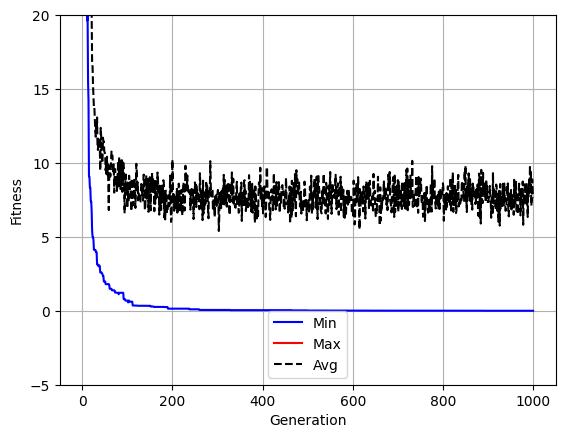

In [67]:
#  Creamos los objetos para definir el problema y el tipo de individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Generación de genes
toolbox.register("attr_uniform", random.uniform, -5.12, 5.12)

# Generación de inviduos y población
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_uniform, n=10)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual)

# Registro de operaciones genéticas
toolbox.register("evaluate", rastrigin)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 3, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def plot_evolucion(log):
    """
    Representa la evolución del mejor individuo en cada generación
    """
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_ave = log.select("avg")

    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_ave, "--k")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    ax1.set_ylim([-5, 20])
    ax1.legend(["Min", "Max", "Avg"], loc="lower center")
    plt.grid(True)
    plt.savefig("Convergencia.eps", dpi = 300)

def main():
    random.seed(0)
    CXPB, MUTPB, NGEN = 0.5, 0.2, 1000
    population_size = 640 # porque es de dimensión 10
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    logbook = tools.Logbook()
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB,
                                       mutpb=MUTPB, ngen=NGEN, stats=stats,
                                       halloffame=hof, verbose=True)
    return hof, logbook

if __name__ == "__main__":
    best, log = main()
    print("Mejor fitness: %f" %best[0].fitness.values)
    print("Mejor individuo %s" %best[0])
    plot_evolucion(log)
    res_one = log.select("min")
    gen = log.select("gen")

La función `plot_evolucion` tiene como propósito visualizar la evolución del algoritmo a lo largo de las generaciones, mostrando gráficos de los valores mínimo, máximo y promedio de la aptitud. Esta visualización es fundamental para comprender cómo el rendimiento del algoritmo evoluciona a medida que progresa en las iteraciones.

A continuación vamos a analizar algunos aspectos a considerar sobre los resultados de la gráfica. En primer lugar se puede observar la convergencia del algoritmo, es decir, la tendencia del algoritmo a acercarse a la solución óptima a medida que avanza en las generaciones. Existe una convergencia hacia el valor mínimo de aptitud, en este caso el 0, indicando que el algoritmo está encontrando soluciones cada vez mejores.

La estabilidad se evalúa observando la variabilidad de los valores de aptitud a lo largo de las generaciones. Los valores se estabilizan hacia el final del proceso evolutivo, cuando el algoritmo ha convergido a una región particular del espacio de búsqueda.

Vamos a analizar ahora la pendiente de la curva de aptitud. Tenemos una pendiente muy pronunciada al principio seguida de una estabilización, lo que sugiere una rápida convergencia inicial seguida de una exploración más cuidadosa en las generaciones posteriores.

Por último, se pueden observar diferencias significativas entre los valores mínimo, máximo y promedio, lo que significa que la población está explorando múltiples regiones del espacio de búsqueda.


**Código para dos puntos de cruce**

gen	nevals	avg    	std    	min    	max   
0  	640   	185.244	33.4823	104.301	285.04
1  	373   	161.415	32.4523	69.0451	379.068
2  	393   	141.078	28.3674	60.2804	282.944
3  	391   	122.565	24.695 	60.2804	309.822
4  	390   	107.677	22.4586	40.8954	248.876
5  	356   	95.252 	22.6664	40.8954	233.517
6  	373   	83.4473	21.6296	43.2754	202.603
7  	411   	75.4152	23.3161	34.2157	249.831
8  	390   	64.784 	19.529 	25.9346	196.882
9  	361   	57.7673	21.0053	27.9527	193.955
10 	404   	52.9946	23.1843	18.4694	214.662
11 	367   	46.8978	22.7738	18.4694	211.226
12 	368   	42.1983	21.643 	10.3666	169.413
13 	369   	36.5881	20.0959	9.69088	180.899
14 	410   	33.7593	23.7419	9.69088	173.959
15 	381   	29.2415	20.5873	9.69088	186.205
16 	363   	25.4129	21.1797	7.17992	231.047
17 	393   	23.6141	20.1695	7.17992	173.988
18 	371   	21.7635	22.9457	7.17992	195.63 
19 	376   	18.1251	21.3187	6.44282	196.492
20 	394   	16.6817	20.8303	5.62808	160.629
21 	371   	15.7575	19.4474	5.28469	131.774
22 	370   	16

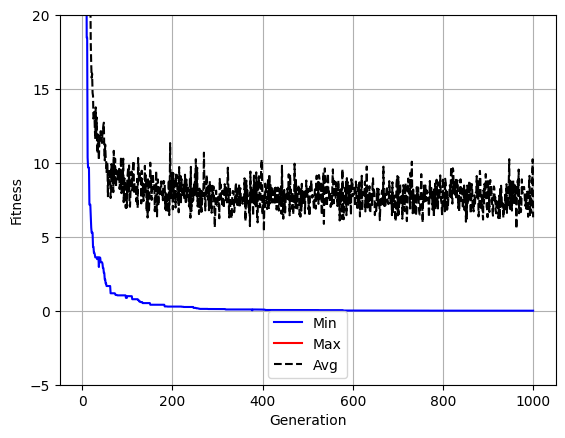

In [68]:
#  Creamos los objetos para definir el problema y el tipo de individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Generación de genes
toolbox.register("attr_uniform", random.uniform, -5.12, 5.12)

# Generación de inviduos y población
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_uniform, n=10)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual)

# Registro de operaciones genéticas
toolbox.register("evaluate", rastrigin)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 3, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    random.seed(0)
    CXPB, MUTPB, NGEN = 0.5, 0.2, 1000
    population_size = 640 # porque dim = 10
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    logbook = tools.Logbook()
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB,
                                       mutpb=MUTPB, ngen=NGEN, stats=stats,
                                       halloffame=hof, verbose=True)
    return hof, logbook

if __name__ == "__main__":
    best, log = main()
    print("Mejor fitness: %f" %best[0].fitness.values)
    print("Mejor individuo %s" %best[0])
    plot_evolucion(log)
    res_two = log.select("min")

A primera vista la gráfica parece muy similar a la obtenida anteriormente con un sólo punto de cruce. Vamos a hacer una comparación más rigurosa de los dos algoritmos a continuación.

**Comparación gráfica**

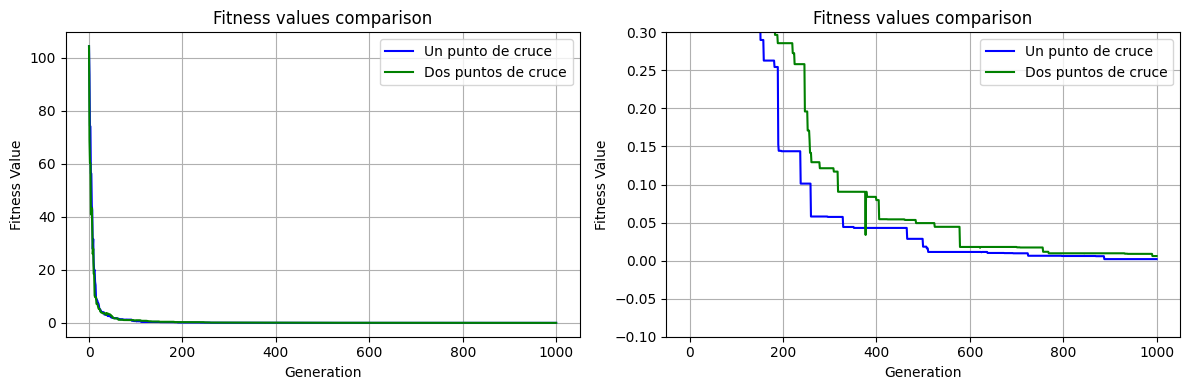

In [69]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(gen, res_one, label='Un punto de cruce', linestyle='-', color='blue')
plt.plot(gen, res_two, label='Dos puntos de cruce', linestyle='-', color='green')
plt.title('Fitness values comparison')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(gen, res_one, label='Un punto de cruce', linestyle='-', color='blue')
plt.plot(gen, res_two, label='Dos puntos de cruce', linestyle='-', color='green')
plt.title('Fitness values comparison')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.ylim(-0.1, 0.3)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Se conoce de antemano que el valor teórico para el mínimo de la función tiene un valor de 0. La comparación de las gráficas demuestra que el algoritmo genético implementado tanto con un punto de cruce como con dos puntos de cruce, converge al mínimo global. Sin embargo, podemos ver que, como el ejercicio 1, elegir un punto de cruce es una mejor opción ya que converge más rápido a la solución.

**Código que mejora la convergencia y no utiliza puntos de cruce**

Una de las características más representativas de la metodología de cruce por mezcla es la de su adaptabilidad a problemas de variada naturaleza. Por ello, a la luz de la eficacia de la función ```tools.cxBlend```, seguiremos la misma metodología para mejorar el proceso de búsqueda del mínimo local de la función Rastrigin.

Cabe destacar que, de acuerdo a la complejidad de la función de estudio en este apartado, esta ocasión se requerirán alrededor de 200 generaciones para asegurar una convergencia óptima del algoritmo.


gen	nevals	avg    	std    	min    	max   
0  	640   	185.244	33.4823	104.301	285.04
1  	411   	191.992	60.4796	98.0237	558.769
2  	365   	178.293	55.9217	64.6252	560.467
3  	371   	170.24 	52.3175	64.6252	521.542
4  	392   	162.144	52.3833	64.6252	448.805
5  	383   	154.683	54.2708	64.6252	458.183
6  	399   	147.546	53.7013	60.3715	422.437
7  	397   	142.454	56.7824	49.6102	485.695
8  	404   	135.555	50.095 	49.6102	380.413
9  	381   	130.656	52.3375	53.1015	499.471
10 	386   	125.294	46.5831	51.3634	358.722
11 	377   	118.205	50.8024	48.6868	350.755
12 	372   	111.784	47.5331	48.6868	449.06 
13 	390   	102.231	43.6717	39.7236	352.938
14 	366   	90.5523	46.9439	36.9798	572.525
15 	364   	80.3074	40.6255	34.5576	350.892
16 	418   	73.8536	37.3543	26.9545	321.77 
17 	371   	68.141 	36.7113	26.9545	289.275
18 	378   	65.3862	37.9345	26.9545	359.073
19 	382   	61.8292	36.4627	26.9545	341.045
20 	359   	58.9634	33.9284	26.9545	287.549
21 	384   	58.6662	37.345 	26.9545	325.75 
22 	369   	55

194	387   	12.8411	40.5971	0.000350711	452.683
195	382   	15.5586	41.6737	0.000290993	335.32 
196	375   	11.342 	32.3302	0.000198431	261.279
197	382   	12.201 	37.236 	0.000198431	344.659
198	382   	9.80158	30.2475	0.00017308 	263.982
199	387   	14.026 	37.4357	5.7748e-05 	294.992
200	397   	14.0116	39.3472	0.00010228 	243.308
Mejor fitness: 0.000058
Mejor individuo [-0.00018055726175616034, -0.0001144104442686671, -7.465517526447445e-05, -0.0002201640102266187, -2.1015659618675098e-05, -4.8468858905757055e-05, -0.0002423018792716409, 0.0003487321854783252, -8.739259461749028e-06, -9.029176491687555e-05]


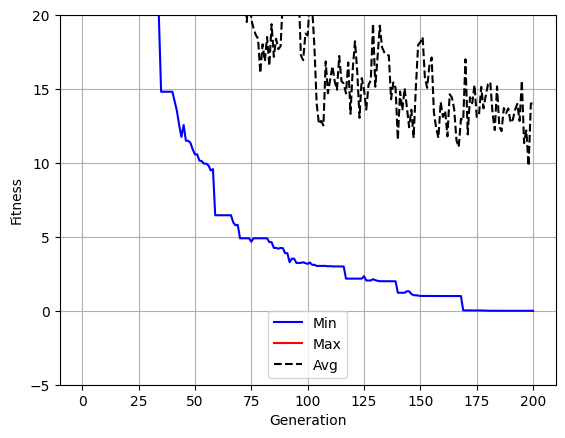

In [70]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Generación de genes
toolbox.register("attr_uniform", random.uniform, -5.12, 5.12)

# Generación de inviduos y población
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_uniform, n=10)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual)

# Registro de operaciones genéticas
toolbox.register("evaluate", rastrigin)
toolbox.register("mate", tools.cxBlend, alpha=0.7)
toolbox.register("mutate", tools.mutGaussian, mu=0,
                 sigma= 4.5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    random.seed(0)
    CXPB, MUTPB, NGEN = 0.5, 0.2, 200
    population_size = 640
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    logbook = tools.Logbook()
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB,
                                       mutpb=MUTPB, ngen=NGEN, stats=stats,
                                       halloffame=hof, verbose=True)
    return hof, logbook

if __name__ == "__main__":
    best, log = main()
    print("Mejor fitness: %f" %best[0].fitness.values)
    print("Mejor individuo %s" %best[0])
    plot_evolucion(log)
    res_three = log.select("min")
    gen = log.select("gen")

Los resultados muestran que entorno a la generación número 200 podemos considerar que el algoritmo ha cumplido con su propósito y ha encontrado un valor que se acerca mucho al mínimo teórico. No obstante, debido a la complejidad oscilatoria de la función de adaptación, se observa que el trazado de la evolución del algoritmo por generación toma un valor de rangos mucho mayor que el caso de la primera función de estudio. Por lo tanto, así se puede explicar la disminución en la velocidad de convergencia de *blend crossover*.


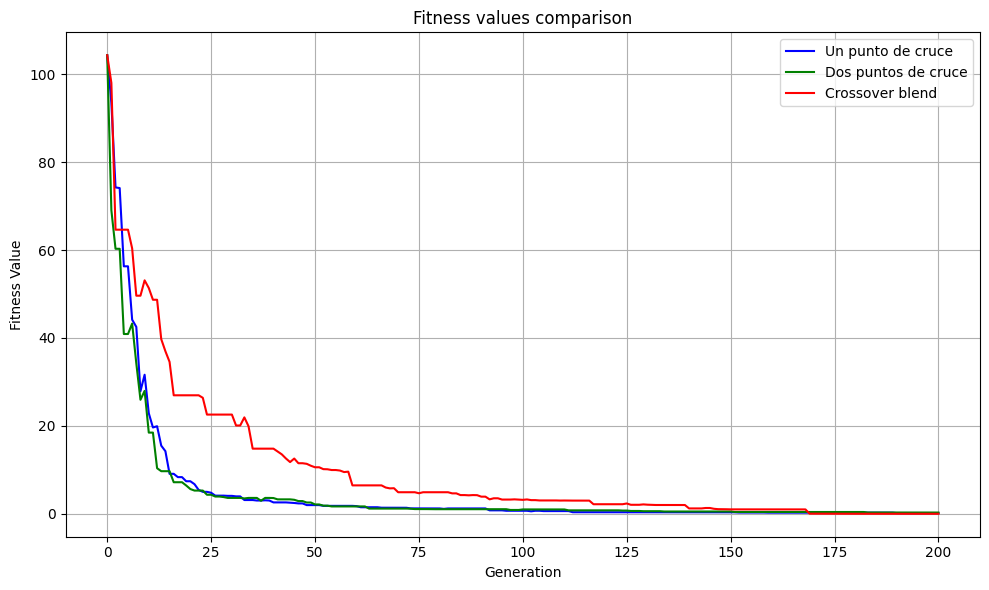

In [71]:
plt.figure(figsize=(10, 6))

plt.plot(gen, res_one[:gen[-1]+1], label='Un punto de cruce', linestyle='-', color='blue')
plt.plot(gen, res_two[:gen[-1]+1], label='Dos puntos de cruce', linestyle='-', color='green')
plt.plot(gen, res_three, label='Crossover blend', linestyle='-', color='red')
plt.title('Fitness values comparison')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

En el caso de la función Rastrigin, sus características consiguen ilustrar las diferencias de eficiencia que muestran las diferentes metodologías escogidas para operar el cruce de individuos. Pues, bien si al principio el cruce por mezcla no consigue alcanzar valores muy bajos, gracias a este proceso previo de exploración es capaz de converger a valores muy próximos al cero en menos de la mitad de generaciones que los algoritmos según puntos de cruce.

Una vez más, se ha probado la importancia de la elección de los hiperparámetros del algoritmo genético y su importancia en la velocidad de convergencia en un problema.